In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import requests
from bs4 import BeautifulSoup

from collections import Counter
from eunjeon import Mecab
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint




전체 리뷰 개수 : 567
   label                                            reviews
0      1  https://m.blog.naver.com/08jiae?Redirect=Log&l...
1      0  https://m.blog.naver.com/2058mangi?Redirect=Lo...
2      0  https://m.blog.naver.com/20l60430?Redirect=Log...
3      0  https://m.blog.naver.com/333goo?Redirect=Log&l...
4      0  https://m.blog.naver.com/3651hit?Redirect=Log&...
총 샘플의 수 : 567
훈련용 리뷰의 개수 : 425
테스트용 리뷰의 개수 : 142
   label  count
0      0    311
1      1    114
label        0
reviews    425
dtype: int64
전처리 후 테스트용 샘플의 개수 : 0


<ipython-input-3-4f5943068cd3>:52: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-3-4f5943068cd3>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\timeb\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-3-4f5943068cd3>:56: SettingWithCopyWarning: 


NotImplementedError: Wrong number or type of arguments for overloaded function 'Tagger_parse'.
  Possible C/C++ prototypes are:
    MeCab::Tagger::parse(MeCab::Model const &,MeCab::Lattice *)
    MeCab::Tagger::parse(MeCab::Lattice *) const
    MeCab::Tagger::parse(char const *)


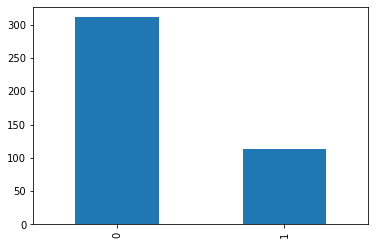

In [3]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

def tag_helper(tag):
    if tag.name == 'img':
        # img tag
        return '[IMG]'
    elif tag.name == 'p':
        # p tag
        return tag.get_text()
    else:
        return ''


def get_content(): # url을 가져와서 텍스트데이터를 출력
    url = 'https://m.blog.naver.com/korfish01?Redirect=Log&logNo=221912889017'
    req = requests.get(url)
    content = req.content

    soup = BeautifulSoup(content, 'html.parser')
    contents = soup.select_one('div.se-main-container')

    result = list(map(tag_helper, contents.find_all(['img', 'p'])))

    return result


urllib.request.urlretrieve("https://raw.githubusercontent.com/timebeat1/NLP-activity-history-weekly-/main/male.txt", filename="male.txt")
#깃허브 raw 데이터 출력입니다. https://raw.githubusercontent.com/ 뒤에 기존 git에 업로드 되어있는 파일 경로를 넣어주면 됩니다.
total_data = pd.read_table('male.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

print(total_data[:5])

total_data['reviews'].nunique(), total_data['label'].nunique()

total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

train_data['label'].value_counts().plot(kind = 'bar')

print(train_data.groupby('label').size().reset_index(name = 'count'))

train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

mecab = Mecab()

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()



단어 집합(vocabulary)의 크기 : 32642
등장 빈도가 1번 이하인 희귀 단어의 수: 13749
단어 집합에서 희귀 단어의 비율: 42.12058084676184
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.214522326752352
단어 집합의 크기 : 18895
[[488, 659, 7, 34, 87, 148, 2424, 603, 26, 9, 69, 48, 232, 110, 38, 39, 53], [159, 300, 18, 20, 63, 3581, 988, 6, 56], [7, 16, 1479, 4]]
[[734, 35, 14, 401, 53, 105, 131, 88, 6457, 457], [4505, 688, 830, 716, 686, 108, 4, 1782, 98, 371, 3376, 83, 562, 1917, 4292, 262, 168, 61, 25, 358, 34, 87, 976, 19, 6288, 6419], [1734, 790, 596, 46, 23, 347]]
리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.11031914467625


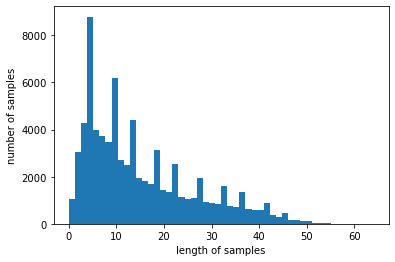

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99733045021956
Epoch 1/15
234/235 [============================>.] - ETA: 0s - loss: 0.5195 - acc: 0.7454
Epoch 1: val_acc improved from -inf to 0.77983, saving model to best_model.h5
235/235 [==============================] - 6s 19ms/step - loss: 0.5194 - acc: 0.7455 - val_loss: 0.4682 - val_acc: 0.7798
Epoch 2/15
233/235 [============================>.] - ETA: 0s - loss: 0.4322 - acc: 0.8035
Epoch 2: val_acc improved from 0.77983 to 0.78651, saving model to best_model.h5
235/235 [==============================] - 4s 16ms/step - loss: 0.4321 - acc: 0.8034 - val_loss: 0.4594 - val_acc: 0.7865
Epoch 3/15
233/235 [============================>.] - ETA: 0s - loss: 0.4052 - acc: 0.8200
Epoch 3: val_acc did not improve from 0.78651
235/235 [==============================] - 4s 16ms/step - loss: 0.4052 - acc: 0.8199 - val_loss: 0.4641 - val_acc: 0.7836
Epoch 4/15
233/235 [============================>.] - ETA: 0s - loss: 0.3834 - acc: 0.8309
Epoch 4: val_acc imp

In [9]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:3])

print(X_test[:3])

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()



max_len = 60
below_threshold_len(max_len, X_train)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))



In [10]:
sentiment_predict('머리에 털나고 이런겜은 처음')

sentiment_predict('클러치 클로가 누구 머리에서 나왔는지...')

sentiment_predict('잘도 그러겠네')

57.34% 확률로 부정 리뷰입니다.
65.32% 확률로 긍정 리뷰입니다.
51.56% 확률로 부정 리뷰입니다.


In [13]:
sentiment_predict('가뭄에 단비같은 게임')

81.70% 확률로 부정 리뷰입니다.


In [16]:
sentiment_predict('노잼')

90.17% 확률로 부정 리뷰입니다.
